# GALAH DR4 Stellar Label Optimisation (Solar Twins)

This script is used to find the optimal set of stellar labels for GALAH spectra in combination with non-spectroscopic information

The code is maintained at
https://github.com/svenbuder/GALAH_DR4
and described at
https://github.com/svenbuder/galah_dr4_paper

Author(s): Sven Buder (ANU, ASTRO 3D)

History:  
211012: Interpolation with The Cannon implemented  
211024: Automatic cross-matches with Gaia EDR3, Cantat-Gaudin, Baumgardt&Vasiliev  
211026: Bayesian Framework implemented  
211029: MCMC implemented  
211105: Masking added based on comparison to Solar atlas
220211: Changing Optimisation to stellar parameters only

In [1]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.constants as c
import logging
import time
import copy
import sys
from pathlib import Path
import pickle
import astropy.units as u
from astropy.table import Table
import scipy.interpolate
from scipy import signal
from scipy.spatial import cKDTree
import scipy.optimize as op
from scipy.ndimage.filters import convolve
from scipy.io import readsav
from scipy.optimize import curve_fit
import emcee
import corner

In [2]:
def hist2d_bin_colored(X,Y,Z,X_label='X\_label',Y_label='Y\_label',Z_label='Z\_label',bins=30,bin_function='median',ax=None,minimum_bin_entries = 5,**kwargs):
    """
    INPUT:
    X : x-axis parameter
    Y : y-axis parameter
    Z : parameter that will be used for coloring the bins
    bin_function : median/average/sum
    
    OUTPUT:
    plt.imshow
    """
    
    # First make sure we only work with finite values
    finite = np.isfinite(X) & np.isfinite(Y) & np.isfinite(Z)
    if len(X[finite])!=len(X):
        print('Not all values were finite! Continuing with only finite ones')
    X=X[finite];Y=Y[finite];Z=Z[finite]
    
    # Now create the matrix of bins and its bin-edges
    H,xedges,yedges = np.histogram2d(X,Y,bins=bins)

    # Create the matrix that we want to store color-values in
    color_matrix = np.zeros_like(H)
    color_matrix[:] = np.nan
    
    # Loop through the x- and y-bins
    for x_bin in range(len(xedges)-1):
        for y_bin in range(len(yedges)-1):
            in_xy_bin = (X>=xedges[x_bin])&(X<xedges[x_bin+1])&(Y>=yedges[y_bin])&(Y<yedges[y_bin+1])
            
            # We only add a value if there are more than *minimum_bin_entries* in the bin
            if len(Z[in_xy_bin]) >= minimum_bin_entries:
                if bin_function=='median':
                    color_matrix[x_bin,y_bin]=np.median(Z[in_xy_bin])
                elif bin_function=='average':
                    color_matrix[x_bin,y_bin]=np.average(Z[in_xy_bin])
                elif bin_function=='sum':
                    color_matrix[x_bin,y_bin]=np.sum(Z[in_xy_bin])
                else:
                    raise NameError('Only bin_function = median/average/sum available')

    # Create an axis if not given
    if ax==None:
        ax = plt.gca()
    else:
        ax=ax
    ax.set_xlabel(X_label)
    ax.set_ylabel(Y_label)

    # Populate the keyword arguments for the imshow
    imshow_kwargs = dict(
        cmap = 'seismic_r',aspect='auto',origin='lower'
    )
    # Update by any arguments given through **kwargs
    imshow_kwargs.update(kwargs)

    # Plot!
    s = ax.imshow(color_matrix.T,extent=(xedges[0],xedges[-1],yedges[0],yedges[-1]),**imshow_kwargs)
    c = plt.colorbar(s, ax=ax)
    c.set_label(Z_label)

In [106]:
# Create dictionary for descriptions
description = dict()
description['sobject_id'] = 'GALAH identifier'
description['tmass_id'] = '2MASS identifier'
description['gaia_edr3_source_id'] = 'Gaia DR2 source_id'
description['flag_sp'] = 'Spectroscopic quality flag'
description['teff'] = 'Spectroscopic effective temperature'
description['logg'] = 'Surface gravity'
description['fe_h'] = 'Fe abundance [Fe/H] (1D-NLTE)'
description['vmic'] = 'Microturbulence velocity'
description['vsini'] = 'Rotational broadening velocity'
for element in ['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu']:
    if element in ['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Mn','Ba']:
        lte_nlte = 'NLTE'
    else:
        lte_nlte = 'LTE'        
    description[element.lower()+'_fe'] = element+' abundance ['+element+'/Fe] (1D-'+lte_nlte+')'
description['vrad'] = 'Radial velocity fitted from spectra'
for ccd in [1,2,3,4]:
    description['cdelt'+str(ccd)] = 'Linear wavelength increase per pixel for CCD'+str(ccd)
    description['crval'+str(ccd)] = 'Wavelength of first pixel for CCD'+str(ccd)
description['distance'] = 'Distance from Sun to star'
description['a_v'] = 'Extinction in V filter'
description['model_name'] = 'Model name of interpolation Teff_logg_fe_h'
description['spectrum_covariances'] = 'Covariances from CurveFit to spectra'

In [107]:
# Create dictionary for units
units = dict()
for each in description.keys():
    units[each] = ''
    if each in ['sobject_id','tmass_id','gaia_edr3_source_id','model_name','spectrum_covariances','flag_sp']:
        pass
    elif each in ['teff']:
        units[each] = 'K'
    elif each in ['logg']:
        units[each] = 'log(cm.s**-2)'
    elif each in ['fe_h']:
        units[each] = 'dex'
    elif each in ['vmic','vsini','vrad']:
        units[each] = 'km s-1'
    elif each[-3:] == '_fe':
        units[each] = 'dex'
    elif each in ['distance']:
        units[each] = 'pc'
    elif each in ['a_v']:
        units[each] = 'mag'
    elif each[:5] in ['cdelt']:
        units[each] = 'Angstroem/pix'
    elif each[:5] in ['crval']:
        units[each] = 'Angstroem'
    else:
        print("'"+each+"',")

In [5]:
print("To Do:")
print("Better isochrone set and interpolation routine from Sanjib")
print("Implement some mechanism that checks the ph_qual flag for chi2 and only uses A?")

To Do:
Better isochrone set and interpolation routine from Sanjib
Implement some mechanism that checks the ph_qual flag for chi2 and only uses A?


In [6]:
if sys.argv[1] != '-f':
    sobject_id = sys.argv[1]
    setup = sys.argv[2]
    
    if 'S' in setup:
        use_spectroscopy = True
    else:
        use_spectroscopy = False

    if 'P' in setup:
        use_photoastrometry = True
    else:
        use_photoastrometry = False
        
    if 'A' in setup:
        use_asteroseismology = True
    else:
        use_asteroseismology = False
    if 'I' in setup:
        use_interferometry = True
    else:
        use_interferometry = False  
else:

    # sobject_id = 170906001601045
    # sobject_id = 170906001601092
#     sobject_id = 170906001601098
    # sobject_id = 170906001601197
    # sobject_id = 170906001601280
#     sobject_id = 140111002601011 # M67
#     sobject_id = 140111002601034 # M67
#     sobject_id = 140111002601037 # M67
#     sobject_id = 140111002601042 # M67
#     sobject_id = 140111002601046 # M67
#     sobject_id = 140111002601049 # M67
#     sobject_id = 140111002601076 # M67
#     sobject_id = 140111002601086 # M67
#     sobject_id = 140111002601139 # M67
#     sobject_id = 140111002601140 # M67
#     sobject_id = 140111002601148 # M67
#     sobject_id = 140111002601152 # M67
#     sobject_id = 140111002601170 # M67
#     sobject_id = 140111002601214 # M67
#     sobject_id = 140111002601221 # M67
#     sobject_id = 140111002601257 # M67
    
    # not available sobject_id = 140308003401188 # 18 Sco
    # not available sobject_id = 140708005801203 # bet Hyi
    # not available sobject_id = 140709001901194 # eta Boo
    # not available sobject_id = 140710002501284 # 18 Sco
    # not available sobject_id = 140710003901284 # 18 Sco
    # not available sobject_id = 150210006401171 # eta Boo
    # not available sobject_id = 150405000901378 # Sun
    
    #sobject_id = 140111004101214
    sobject_id = 170205005901355 # HD 121004 from Nissen et al. (2010)
    # sobject_id = 171102005001013 # G112-43 from Nissen et al. (2010)
    ## ^ Use 171102005001013 to implement optimisation of RV fit (and CDELT1?) and normalisation
    
    use_spectroscopy = True
    use_photoastrometry = False
    use_asteroseismology = False
    use_interferometry = False
    
    use_cannon_or_payne = 'payne' # options: 'payne' or 'cannon'
    
print('sobject_id: ',sobject_id)
print('use_spectroscopy:     ',use_spectroscopy)
print('use_photoastrometry:  ',use_photoastrometry)
print('use_asteroseismology: ',use_asteroseismology)
print('use_interferometry:   ',use_interferometry)
print('Using The Cannon or The Payne?',use_cannon_or_payne)

debug = False

working_directory = '/Users/svenbuder/GALAH_DR4/'
spectra_directory = working_directory+'observations/'

if use_cannon_or_payne == 'cannon':
    model_directory = working_directory+'spectrum_interpolation/TheCannon/models/'
    import thecannon as tc
if use_cannon_or_payne == 'payne':
    model_directory = working_directory+'spectrum_interpolation/ThePayne/models/'
    from The_Payne import spectral_model

sobject_id:  170205005901355
use_spectroscopy:      True
use_photoastrometry:   False
use_asteroseismology:  False
use_interferometry:    False
Using The Cannon or The Payne? payne


# Get observation and initial parameters

In [7]:
print('ToDo: What do we do if not LSF is reported?')

ToDo: What do we do if not LSF is reported?


In [8]:
def get_reduction_products(sobject_id, neglect_ir_beginning=True):

    """
    This function collects the spectrum and other reduction products.
    
    INPUT:
    sobject_id: identifier for spectra
    neglect_ir_beginning: Cut away CCD4 information below 7700Å?

    OUTPUT:
    spectrum - dictionary with the following keywords:
    - sobject_id: identifier for GALAH
    - tmass_id: identifier for 2MASS
    - gaia_edr3_source_id: identifier for GaiaEDR3
    - init_teff: Teff value suggested by reduction
    - init_logg: logg value suggested by reduction
    - init_fe_h: [Fe/H] value suggested by reduction
    - init_x_fe: [X/Fe] for alpha-process elements C, O, Mg, Si, Ca, Ti
    - init_vmic: vmic value suggested by reduction
    - init_vsini: vsini value suggested by reduction
    - init_vrad: vrad value suggested by reduction

    """
    spectrum = dict()

    spectrum['sobject_id'] = sobject_id

    fits_file = fits.open(spectra_directory+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+'1.fits')

    spectrum['galah_id'] = fits_file[0].header['GALAH_ID']
    spectrum['tmass_id'] = fits_file[0].header['2MASS_ID']
    spectrum['gaia_edr3_source_id'] = int(fits_file[0].header['GAIA_ID'])

    if fits_file[0].header['SLITMASK'] in ['IN','IN      ']:
        spectrum['resolution'] = 'high-res'
        print('Warning: Spectrum is high-resolution!')
    else:
        spectrum['resolution'] = 'low-res'
    
    if fits_file[0].header['PAR_OK']==1:
        
        # TEFF
        spectrum['init_teff'] = 0.001*fits_file[0].header['TEFF_R']
        if spectrum['init_teff'] < 3:
            raise ValueError('TEFF < 3000')
        if spectrum['init_teff'] > 8:
            raise ValueError('TEFF > 8000')
        
        # LOGG
        spectrum['init_logg'] = fits_file[0].header['LOGG_R']
        if spectrum['init_logg'] < -0.5:
            raise ValueError('LOGG < -0.5')
        if spectrum['init_logg'] > 5.5:
            raise ValueError('LOGG > 5.5')
            
        # FE_H
        spectrum['init_fe_h'] = fits_file[0].header['FE_H_R']
        if spectrum['init_fe_h'] < -4.0:
            raise ValueError('LOGG < -4.0')
        if spectrum['init_fe_h'] > 1.0:
            raise ValueError('LOGG > 1.0')
        
        for element in ['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu']:
            spectrum['init_'+element.lower()+'_fe'] = 0.0

        # ALPHA_FE -> C, O, Si, Mg, Ca, Ti
        for each_alpha in ['c','o','mg','si','ca','ti']:
            spectrum['init_'+each_alpha+'_fe'] = fits_file[0].header['A_FE_R']
            if spectrum['init_'+each_alpha+'_fe'] < -1.0:
                raise ValueError('['+each_alpha+'/Fe] < -1.0')
            if spectrum['init_'+each_alpha+'_fe'] > 1.0:
                raise ValueError('['+each_alpha+'/Fe] > 1.0')
            
        # VMIC
        spectrum['init_vmic'] = fits_file[0].header['VMIC_R']
        
        # VBROAD
        spectrum['init_vsini'] = fits_file[0].header['VBROAD_R']

    else:
        raise ValueError('Reduction parameters not trustworthy!')

    if fits_file[0].header['RVCOM_OK']==1:
        spectrum['init_vrad'] = fits_file[0].header['RVCOM']
    else:
        raise ValueError('RV pipeline did not converge!')

    if fits_file[0].header['WAV_OK']==0:
        raise ValueError('Wavelength solution not ok!')

    if fits_file[0].header['CROSS_OK']==0:
        raise ValueError('Cross-talk not calculated reliably!')

    for ccd in [1,2,3,4]:

        if ccd != 1:
            fits_file = fits.open(spectra_directory+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+str(ccd)+'.fits')

        spectrum['crval_ccd'+str(ccd)] = fits_file[0].header['CRVAL1']
        spectrum['cdelt_ccd'+str(ccd)] = fits_file[0].header['CDELT1']

        spectrum['counts_ccd'+str(ccd)]   = fits_file[0].data
        spectrum['counts_unc_ccd'+str(ccd)] = fits_file[0].data * fits_file[2].data

        spectrum['sky_ccd'+str(ccd)]   = fits_file[3].data
        spectrum['telluric_ccd'+str(ccd)]   = fits_file[4].data

        spectrum['lsf_b_ccd'+str(ccd)] = fits_file[0].header['B']
        spectrum['lsf_ccd'+str(ccd)]   = fits_file[7].data

        if np.shape(spectrum['lsf_ccd'+str(ccd)])[0] == 1:
            spectrum['lsf_ccd'+str(ccd)] = np.ones(len(spectrum['counts_ccd'+str(ccd)]))
            if ccd == 1:
                print('No LSF reported for CCD'+str(ccd)+', using 0.20 everywhere')
                spectrum['lsf_ccd'+str(ccd)] *= 0.2
            if ccd == 2:
                print('No LSF reported for CCD'+str(ccd)+', using 0.25 everywhere')
                spectrum['lsf_ccd'+str(ccd)] *= 0.25
            if ccd == 3:
                print('No LSF reported for CCD'+str(ccd)+', using 0.30 everywhere')
                spectrum['lsf_ccd'+str(ccd)] *= 0.3
            if ccd == 4:
                print('No LSF reported for CCD'+str(ccd)+', using 0.35 everywhere')
                spectrum['lsf_ccd'+str(ccd)] *= 0.35

        fits_file.close()

        if (ccd == 4) & neglect_ir_beginning:
            wave_ccd4 = spectrum['crval_ccd4'] + spectrum['cdelt_ccd4'] * np.arange(len(spectrum['counts_ccd4']))
            bad_ir = wave_ccd4 > 7680
                        
            spectrum['crval_ccd4'] = wave_ccd4[bad_ir][0]
            spectrum['counts_ccd4'] = spectrum['counts_ccd4'][bad_ir]
            spectrum['counts_unc_ccd4'] = spectrum['counts_unc_ccd4'][bad_ir]
            spectrum['lsf_ccd4'] = spectrum['lsf_ccd4'][bad_ir]

    return(spectrum)

spectrum = get_reduction_products(sobject_id)

In [9]:
def exchange_with_reliable_galah_dr3_values(spectrum):

    galah_dr3 = Table.read('../auxiliary_information/GALAH_DR3_main_allspec_v2_lite.fits')
    galah_dr3_match = np.where(galah_dr3['sobject_id'] == spectrum['sobject_id'])[0]
    if len(galah_dr3_match) > 0:
        print('Found match in GALAH+ DR3')
        galah_dr3_entry = galah_dr3[galah_dr3_match[0]]

        if galah_dr3_entry['flag_sp'] == 0:
            print('Replacing initial value for Teff, logg, vmic, vsini with GALAH+ DR3 ones.')
            print('Teff IRAF 6.0: ',"{:.2f}".format(1000.*spectrum['init_teff']), 'GALAH+ DR3: ',"{:.2f}".format(galah_dr3_entry['teff']))
            spectrum['init_teff'] = 0.001*galah_dr3_entry['teff']
            
            for label in ['logg','vmic','vsini']:
                label2 = label
                if label=='vsini':
                    label2 = 'vbroad'
                print(label+' IRAF 6.0: ',"{:.2f}".format(spectrum['init_'+label]), 'GALAH+ DR3: ',"{:.2f}".format(galah_dr3_entry[label2]))
                spectrum['init_'+label] = galah_dr3_entry[label2]

            if galah_dr3_entry['flag_fe_h'] == 0:
                print('Replacing initial value for [Fe/H] with GALAH+ DR3 ones.')
                print('[Fe/H] IRAF 6.0: ',"{:.2f}".format(spectrum['init_fe_h']), 'GALAH+ DR3: ',"{:.2f}".format(galah_dr3_entry['fe_h']))
                spectrum['init_fe_h'] = galah_dr3_entry['fe_h']

            for element in ['Li','C','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu']:
                if galah_dr3_entry['flag_'+element+'_fe'] == 0:
                    print('['+element+'/Fe] initial value from GALAH+ DR3: '+"{:.2f}".format(galah_dr3_entry[element+'_fe']))

                    spectrum['init_'+element.lower()+'_fe'] = galah_dr3_entry[element+'_fe']

exchange_with_reliable_galah_dr3_values(spectrum)

Found match in GALAH+ DR3
Replacing initial value for Teff, logg, vmic, vsini with GALAH+ DR3 ones.
Teff IRAF 6.0:  5539.62 GALAH+ DR3:  5617.58
logg IRAF 6.0:  4.07 GALAH+ DR3:  4.34
vmic IRAF 6.0:  1.09 GALAH+ DR3:  1.12
vsini IRAF 6.0:  4.69 GALAH+ DR3:  5.79
Replacing initial value for [Fe/H] with GALAH+ DR3 ones.
[Fe/H] IRAF 6.0:  -0.69 GALAH+ DR3:  -0.73
[O/Fe] initial value from GALAH+ DR3: 0.56
[Na/Fe] initial value from GALAH+ DR3: 0.13
[Mg/Fe] initial value from GALAH+ DR3: 0.34
[Al/Fe] initial value from GALAH+ DR3: 0.29
[Si/Fe] initial value from GALAH+ DR3: 0.27
[K/Fe] initial value from GALAH+ DR3: 0.22
[Ca/Fe] initial value from GALAH+ DR3: 0.24
[Sc/Fe] initial value from GALAH+ DR3: 0.22
[Ti/Fe] initial value from GALAH+ DR3: 0.30
[V/Fe] initial value from GALAH+ DR3: -0.04
[Cr/Fe] initial value from GALAH+ DR3: -0.09
[Mn/Fe] initial value from GALAH+ DR3: -0.21
[Ni/Fe] initial value from GALAH+ DR3: -0.02
[Cu/Fe] initial value from GALAH+ DR3: -0.08
[Zn/Fe] initial val

In [10]:
# Correction of Gaia Gband magnitude and flux.
# The code is listed in the appendix of Gaia Collaboration et al. (2021), and 
# implements the formulae presented in Riello et al. (2021): https://ui.adsabs.harvard.edu/abs/2021A%26A...649A...3R/abstract
# Code retrieved from https://github.com/agabrown/gaiaedr3-6p-gband-correction/ 

def correct_gband(bp_rp, astrometric_params_solved, phot_g_mean_mag, phot_g_mean_flux):
    """
    Correct the G-band fluxes and magnitudes for the input list of Gaia EDR3 data.
    
    Parameters
    ----------
    
    bp_rp: float, numpy.ndarray
        The (BP-RP) colour listed in the Gaia EDR3 archive.
    astrometric_params_solved: int, numpy.ndarray
        The astrometric solution type listed in the Gaia EDR3 archive.
    phot_g_mean_mag: float, numpy.ndarray
        The G-band magnitude as listed in the Gaia EDR3 archive.
    phot_g_mean_flux: float, numpy.ndarray
        The G-band flux as listed in the Gaia EDR3 archive.
        
    Returns
    -------
    
    The corrected G-band magnitudes and fluxes. The corrections are only applied to
    sources with a 2-paramater or 6-parameter astrometric solution fainter than G=13, 
    for which a (BP-RP) colour is available.
    
    Example
    -------
    
    gmag_corr, gflux_corr = correct_gband(bp_rp, astrometric_params_solved, phot_g_mean_mag, phot_g_mean_flux)
    """

    if np.isscalar(bp_rp) or np.isscalar(astrometric_params_solved) or np.isscalar(phot_g_mean_mag) \
                    or np.isscalar(phot_g_mean_flux):
        bp_rp = np.float64(bp_rp)
        astrometric_params_solved = np.int64(astrometric_params_solved)
        phot_g_mean_mag = np.float64(phot_g_mean_mag)
        phot_g_mean_flux = np.float64(phot_g_mean_flux)
    
    if not (bp_rp.shape == astrometric_params_solved.shape == phot_g_mean_mag.shape == phot_g_mean_flux.shape):
        raise ValueError('Function parameters must be of the same shape!')
    
    do_not_correct = np.isnan(bp_rp) | (phot_g_mean_mag<13) | (astrometric_params_solved == 31)
    bright_correct = np.logical_not(do_not_correct) & (phot_g_mean_mag>=13) & (phot_g_mean_mag<=16)
    faint_correct = np.logical_not(do_not_correct) & (phot_g_mean_mag>16)
    bp_rp_c = np.clip(bp_rp, 0.25, 3.0)
    
    correction_factor = np.ones_like(phot_g_mean_mag)
    correction_factor[faint_correct] = 1.00525 - 0.02323*bp_rp_c[faint_correct] + \
        0.01740*np.power(bp_rp_c[faint_correct],2) - 0.00253*np.power(bp_rp_c[faint_correct],3)
    correction_factor[bright_correct] = 1.00876 - 0.02540*bp_rp_c[bright_correct] + \
        0.01747*np.power(bp_rp_c[bright_correct],2) - 0.00277*np.power(bp_rp_c[bright_correct],3)
    
    gmag_corrected = phot_g_mean_mag - 2.5*np.log10(correction_factor)
    gflux_corrected = phot_g_mean_flux * correction_factor
    
    return gmag_corrected, gflux_corrected

In [11]:
def get_non_spec_info(spectrum, use_photoastrometry, use_asteroseismology):
    """
    Get the non-spectroscopic information from the auxiliary information.
    X-matches to 2MASS, Gaia eDR3, and K2
    
    INPUT:
    spectrum dictionary with sobject_id and gaia_edr_source_id keywords
    use_photoastrometry : True/False statement to use Gaia+2MASS+WISE photometry (g_bp, ks_m, W2, etc.) + Gaia astrometry (parallax)
    use_asteroseismology : True/False statement to use asteroseismology (nu_max and delta_nu)
    
    OUTPUT:
    dictionary with the important information
    from Gaia eDR3, 2MASS, WISE, and K2 (if available)
    """

    non_spec_info = dict()
    non_spec_info['sobject_id'] = spectrum['sobject_id']
    non_spec_info['tmass_id'] = spectrum['tmass_id']
    non_spec_info['gaia_edr3_source_id'] = spectrum['gaia_edr3_source_id']

    print('Matching with Gaia eDR3 and 2MASS via TAP query')
    if use_photoastrometry:
        
        # Query to get Gaia eDR3 and 2MASS information.
        # At the moment, we do not match with other surveys, but we easily could, as indicated below
        
        adql = [
            'SELECT TOP 2',
            'gaia_edr3.ruwe, gaia_edr3.astrometric_params_solved, gaia_edr3.nu_eff_used_in_astrometry, gaia_edr3.pseudocolour, gaia_edr3.ecl_lat,',
            'gaia_edr3.bp_rp, gaia_edr3.phot_g_mean_mag, gaia_edr3.phot_bp_mean_mag, gaia_edr3.phot_rp_mean_mag,',
            'gaia_edr3.phot_g_mean_flux, gaia_edr3.phot_bp_mean_flux, gaia_edr3.phot_rp_mean_flux,',
            'gaia_edr3.phot_g_mean_flux_error, gaia_edr3.phot_bp_mean_flux_error, gaia_edr3.phot_rp_mean_flux_error,',
            'gaia_edr3.parallax, gaia_edr3.parallax_error,',
            'gaia_edr3.dr2_radial_velocity, gaia_edr3.dr2_radial_velocity_error,',
            'tmass.designation as tmass_id,',
            'tmass.ph_qual as ph_qual_tmass,',
            'tmass.j_m, tmass.j_msigcom,',
            'tmass.h_m, tmass.h_msigcom,',
            'tmass.ks_m, tmass.ks_msigcom',
            'FROM gaiaedr3.gaia_source as gaia_edr3',
            'JOIN gaiaedr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)',
            'JOIN gaiaedr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)',
            'JOIN gaiadr1.tmass_original_valid AS tmass',
            'ON xjoin.original_psc_source_id = tmass.designation',
            # We could extend to use of Allwise (but check multiple keywords like ph_qual)
            #'INNER JOIN gaiaedr3.allwise_best_neighbour as allwise_xmatch',
            #'ON gaia_edr3.source_id = allwise_xmatch.source_id',
            #'INNER JOIN gaiadr1.allwise_original_valid as allwise',
            #'ON allwise.allwise_oid = allwise_xmatch.allwise_oid',
            'WHERE gaia_edr3.source_id = '+str(spectrum['gaia_edr3_source_id'])
        ]

        try:
            job = Gaia.launch_job(' '.join(adql))
            adql_result = job.get_results()
        except:
            print(' '.join(adql))
            raise ValueError('No match with via gaiaedr3.source_id found')

        if np.shape(adql_result)[0] > 1:
            print(' '.join(adql))
            raise ValueError('More than 1 match with via gaiaedr3.source_id found')

        # Prepare the photometric information from Gaia eDR3
        Gmag, FG = correct_gband(
            bp_rp = adql_result['bp_rp'][0], 
            astrometric_params_solved = adql_result['astrometric_params_solved'][0], 
            phot_g_mean_mag = adql_result['phot_g_mean_mag'][0], 
            phot_g_mean_flux = adql_result['phot_g_mean_flux'][0]
        )
        non_spec_info['gmag_gaia_edr3'] = Gmag * u.mag
        non_spec_info['gbpmag_gaia_edr3'] = adql_result['phot_bp_mean_mag'][0] * u.mag
        non_spec_info['grpmag_gaia_edr3'] = adql_result['phot_rp_mean_mag'][0] * u.mag

        # Calculation of Gaia eDR3 G/GBP/GRP uncertainties:
        # See both https://www.cosmos.esa.int/web/gaia/edr3-passbands
        # and https://cdsarc.unistra.fr/viz-bin/ReadMe/I/350?format=html&tex=true#sRM3.63
        sigmaG_0 = 0.0027553202
        sigmaGBP_0 = 0.0027901700
        sigmaGRP_0 = 0.0037793818
        non_spec_info['e_gmag_gaia_edr3']   = np.sqrt((-2.5/np.log(10)*adql_result['phot_g_mean_flux_error'][0]/FG)**2 + sigmaG_0**2) * u.mag
        non_spec_info['e_gbpmag_gaia_edr3'] = np.sqrt((-2.5/np.log(10)*adql_result['phot_bp_mean_flux_error'][0]/adql_result['phot_bp_mean_flux'][0])**2 + sigmaGBP_0**2) * u.mag
        non_spec_info['e_grpmag_gaia_edr3'] = np.sqrt((-2.5/np.log(10)*adql_result['phot_rp_mean_flux_error'][0]/adql_result['phot_rp_mean_flux'][0])**2 + sigmaGRP_0**2) * u.mag

        # Calculations of Parallax Zeropoint Corrections:
        # Following script by Lindegren et al. (2021b)
        # https://ui.adsabs.harvard.edu/abs/2021A&A...649A...4L
        if adql_result['astrometric_params_solved'][0] in [31,95]:
            # Parallax zeropoint corretion for 
            parallax_zeropoint_correction = zpt.get_zpt(
                phot_g_mean_mag = adql_result['phot_g_mean_mag'][0],
                nu_eff_used_in_astrometry = adql_result['nu_eff_used_in_astrometry'][0],
                pseudocolour = adql_result['pseudocolour'][0],
                ecl_lat = adql_result['ecl_lat'][0],
                astrometric_params_solved = adql_result['astrometric_params_solved'][0]
            )
        else:
            parallax_zeropoint_correction = 0.

        if np.isfinite(adql_result['dr2_radial_velocity_error'][0]):
            non_spec_info['rv_gaia_edr3'] = adql_result['dr2_radial_velocity'][0] * u.km/u.s
            non_spec_info['e_rv_gaia_edr3'] = adql_result['dr2_radial_velocity_error'][0] * u.km/u.s
        else:
            non_spec_info['rv_gaia_edr3'] = np.nan
            non_spec_info['e_rv_gaia_edr3'] = np.nan

        non_spec_info['ruwe_gaia_edr3'] = adql_result['ruwe'][0]
        
        non_spec_info['parallax_raw_gaia_edr3'] = adql_result['parallax'][0] * u.mas
        non_spec_info['parallax_gaia_edr3'] = (adql_result['parallax'][0] - parallax_zeropoint_correction) * u.mas
        non_spec_info['e_parallax_gaia_edr3'] = adql_result['parallax_error'][0] * u.mas
        
        non_spec_info['parallax'] = non_spec_info['parallax_gaia_edr3']
        non_spec_info['e_parallax'] = non_spec_info['e_parallax_gaia_edr3']

        # Check entries in open cluster catalog by Cantat-Gaudin et al., 2020, A&A 640, 1
        cantatgaudin2020_parallaxes = Table.read('../auxiliary_information/CantatGaudin_2020_AandA_640_1.fits')
        cantatgaudin2020_match = np.where(spectrum['gaia_edr3_source_id'] == cantatgaudin2020_parallaxes['GaiaDR2'])[0]
        # If there is an entry in this catalog
        if len(cantatgaudin2020_match) > 0:
            non_spec_info['parallax_cg2020'] = cantatgaudin2020_parallaxes['plx'][cantatgaudin2020_match[0]] * u.mas
            non_spec_info['e_parallax_cg2020'] = cantatgaudin2020_parallaxes['e_plx'][cantatgaudin2020_match[0]] * u.mas
            # replace parallax to be used, if Cantat-Gaudin et al. parallax has smaller uncertainty
            print(r'Gaia EDR3:                   $'+"{:.3f}".format(non_spec_info['parallax'])+' \pm '+"{:.3f}".format(non_spec_info['e_parallax'])+'$')
            print(r'Cantat-Gaudin et al. (2020): $'+"{:.3f}".format(non_spec_info['parallax_cg2020'])+' \pm '+"{:.3f}".format(non_spec_info['e_parallax_cg2020'])+'$')
            if non_spec_info['e_parallax_cg2020'] < non_spec_info['e_parallax']:
                print('Open cluster entry by Cantat-Gaudin et al. (2020) more precise')
                non_spec_info['parallax'] = non_spec_info['parallax_cg2020']
                non_spec_info['e_parallax'] = non_spec_info['e_parallax_cg2020']
            else:
                print('Open cluster entry by Cantat-Gaudin et al. (2020) less precise')
        else:
            print('No entry in Cantat-Gaudin et al. (2020) found')

        # Check entries in open cluster catalog by Cantat-Gaudin et al., 2020, A&A 640, 1
        vasiliev2021_parallaxes = Table.read('../auxiliary_information/VasilievBaumgardt_2021_MNRAS_505_5978_8GCs_70percent.fits')
        vasiliev2021_match = np.where(spectrum['gaia_edr3_source_id'] == vasiliev2021_parallaxes['source_id'])[0]
        # If there is an entry in this catalog
        if len(vasiliev2021_match) > 0:
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_104_47Tuc':
                non_spec_info['parallax_vb21'] = 0.232 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.009 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_288':
                non_spec_info['parallax_vb21'] = 0.141 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.011 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_362':
                non_spec_info['parallax_vb21'] = 0.114 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.011 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_1851':
                non_spec_info['parallax_vb21'] = 0.088 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.011 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_5139_oCen':
                non_spec_info['parallax_vb21'] = 0.193 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.009 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_6362':
                non_spec_info['parallax_vb21'] = 0.136 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.010 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_6397':
                non_spec_info['parallax_vb21'] = 0.416 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.010 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_7099_M_30':
                non_spec_info['parallax_vb21'] = 0.136 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.011 * u.mas
            
            # replace parallax to be used, if Cantat-Gaudin et al. parallax has smaller uncertainty
            print(r'Gaia EDR3:                   $'+"{:.3f}".format(non_spec_info['parallax'])+' \pm '+"{:.3f}".format(non_spec_info['e_parallax'])+'$')
            print(r'Vasiliev & Baumgardt (2021): $'+"{:.3f}".format(non_spec_info['parallax_vb21'])+' \pm '+"{:.3f}".format(non_spec_info['e_parallax_vb21'])+'$')
            if non_spec_info['e_parallax_vb21'] < non_spec_info['e_parallax']:
                print('Globular cluster entry by Vasiliev & Baumgardt (2021) more precise')
                non_spec_info['parallax'] = non_spec_info['parallax_vb21']
                non_spec_info['e_parallax'] = non_spec_info['e_parallax_vb21']
            else:
                print('Globular cluster entry by Vasiliev & Baumgardt (2021) less precise:')
        else:
            print('No entry in Vasiliev & Baumgardt (2021) found')
                
        if spectrum['tmass_id'] == '16103957-2602249':
            non_spec_info['ph_qual_tmass'] = 'AAA'
            non_spec_info['jmag_tmass'] = 7.996 * u.mag
            non_spec_info['e_jmag_tmass'] = 0.026 * u.mag
            non_spec_info['hmag_tmass'] = 7.431 * u.mag
            non_spec_info['e_hmag_tmass'] = 0.038 * u.mag
            non_spec_info['ksmag_tmass'] = 7.265 * u.mag
            non_spec_info['e_ksmag_tmass'] = 0.016 * u.mag

        else:
            #Prepare the photometric information from 2MASS
            if spectrum['tmass_id'] != str(adql_result['tmass_id'][0])[2:-1]:
                print(' '.join(adql))
                print('GALAH internal 2MASS ID', spectrum['tmass_id'])
                print('Gaia eDR3 matched  2MASS ID', str(adql_result['tmass_id'][0])[2:-1])
                raise ValueError('Gaia eDR3 crossmatch to 2MASS is not consistent with our 2MASS ID')

            non_spec_info['ph_qual_tmass'] = str(adql_result['ph_qual_tmass'][0])[2:-1]
            non_spec_info['jmag_tmass'] = adql_result['j_m'][0] * u.mag
            non_spec_info['e_jmag_tmass'] = adql_result['j_msigcom'][0] * u.mag
            non_spec_info['hmag_tmass'] = adql_result['h_m'][0] * u.mag
            non_spec_info['e_hmag_tmass'] = adql_result['h_msigcom'][0] * u.mag
            non_spec_info['ksmag_tmass'] = adql_result['ks_m'][0] * u.mag
            non_spec_info['e_ksmag_tmass'] = adql_result['ks_msigcom'][0] * u.mag

    if use_asteroseismology:
        # information from K2
        K2 = Table.read('../auxiliary_information/Zinn_Table2_eDR3_xmatch.fits')
        match = np.where(K2['source_id'] == non_spec_info['gaia_edr3_source_id'])[0]
    
        if len(match) > 0:
            if len(match) > 1:
                print('Multiple matches between K2 and Gaia eDR3 found!')

            non_spec_info['epic_id'] = K2['epic_id'][match[0]]

            non_spec_info['nu_max'] = K2['numax_mean'][match[0]] * u.microHertz
            if np.isfinite(K2['numax_scatter'][match[0]]):
                non_spec_info['e_nu_max'] = K2['numax_scatter'][match[0]] * u.microHertz
            else:
                print('No uncertainty for nu_max value')
                non_spec_info['e_nu_max'] = np.nan

            non_spec_info['delta_nu'] = K2['dnu_mean_corr'][match[0]] * u.microHertz
            if np.isfinite(K2['dnu_mean_corr'][match[0]]):
                non_spec_info['e_delta_nu'] = K2['dnu_mean_corr'][match[0]] * u.microHertz
            else:
                print('No uncertainty for delta_nu value')
                non_spec_info['e_delta_nu'] = np.nan
        else:
            raise ValueError('No match with K2 asteroseismic table found!')

    return(non_spec_info)

if use_photoastrometry:
    # Corrections to non-spectroscopic data
    from astroquery.gaia import Gaia
    from zero_point import zpt
    zpt.load_tables()
    
    # Read in isochrone grid and trained nearest neighbor search machinery 'kdtree'
    parsec = Table.read('../auxiliary_information/parsec_isochrones/parsec_isochrones_logt_6p19_0p01_10p17_mh_m2p75_0p25_m0p75_mh_m0p60_0p10_0p70_GaiaEDR3_2MASS.fits')
    # parsec = Table.read('../auxiliary_information/parsec_isochrones/parsec_isochrones_logt_6p19_0p01_10p17_mh_m2p75_0p25_1p00_mh_m0p75_0p05_0p75_GaiaEDR3_2MASS.fits')
    file = open('../auxiliary_information/parsec_isochrones/isochrone_kdtree_Teff_logg_M_H.pickle','rb')
    parsec_kdtree = pickle.load(file)
    file.close()

if use_photoastrometry | use_asteroseismology:
    
    non_spec_info = get_non_spec_info(spectrum, use_photoastrometry, use_asteroseismology)

In [12]:
grids = Table.read('../spectrum_grids/galah_dr4_model_trainingset_gridpoints.fits')
grid_index_tree = cKDTree(np.c_[grids['teff_subgrid'],grids['logg_subgrid'],grids['fe_h_subgrid']])
default_model_index = grid_index_tree.query([spectrum['init_teff']*1000,spectrum['init_logg'],spectrum['init_fe_h']],k=1)[1]
default_model_teff_logg_feh = str(int(grids['teff_subgrid'][default_model_index]))+'_'+"{:.2f}".format(grids['logg_subgrid'][default_model_index])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][default_model_index])
print(default_model_index,default_model_teff_logg_feh)

if use_cannon_or_payne == 'cannon':
    # Load CANNON Models
    #cannon_models = Table.read(cannon_model_directory+'Cannon_subgrid.fits')
    #cannon_index_tree = cKDTree(np.c_[cannon_models['teff'],cannon_models['logg'],cannon_models['fe_h']])

    default_model_name = '../spectrum_interpolation/TheCannon/models/galah_dr4_thecannon_model_'+default_model_teff_logg_feh+'_order2_36labels.model'
    default_model = tc.CannonModel.read(default_model_name)

if use_cannon_or_payne == 'payne':
    
    #default_model_name = '../spectrum_interpolation/ThePayne/models/galah_dr4_thepayne_model_'+default_model_teff_logg_feh+'_36labels.npz'

    try:
        default_model_name = '../spectrum_interpolation/ThePayne/models/galah_dr4_thepayne_model_extra6_'+default_model_teff_logg_feh+'_36labels.npz'
        tmp = np.load(default_model_name)
        print('Using extra6 '+default_model_teff_logg_feh)
    except:
        try:
            default_model_name = '../spectrum_interpolation/ThePayne/models/galah_dr4_thepayne_model_'+default_model_teff_logg_feh+'_36labels.npz'
            tmp = np.load(default_model_name)
            print('Using single '+default_model_teff_logg_feh)
        except:
            default_model_name = '../spectrum_interpolation/ThePayne/models/galah_dr4_thepayne_model_extra6_5750_4.50_0.00_36labels.npz'
            default_model_teff_logg_feh = '5750_4.50_0.00'
            print('Changed default model to '+default_model_teff_logg_feh)

    tmp = np.load(default_model_name)
    w_array_0 = tmp["w_array_0"]
    w_array_1 = tmp["w_array_1"]
    w_array_2 = tmp["w_array_2"]
    b_array_0 = tmp["b_array_0"]
    b_array_1 = tmp["b_array_1"]
    b_array_2 = tmp["b_array_2"]
    x_min = tmp["x_min"]
    x_max = tmp["x_max"]
    tmp.close()
    default_model = (w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max)

1842 5500_4.50_-0.75
Using single 5500_4.50_-0.75


In [13]:
# Load Spectrum masks
masks = Table.read('spectrum_masks/solar_spectrum_mask.fits')

wavelength_file = '../spectrum_interpolation/training_input/galah_dr4_3dbin_wavelength_array.pickle'
wavelength_file_opener = open(wavelength_file,'rb')
default_model_wave = pickle.load(wavelength_file_opener)
wavelength_file_opener.close()

In [14]:
model_labels = np.loadtxt('../spectrum_interpolation/gradient_spectra/'+default_model_teff_logg_feh+'/recommended_fit_labels_'+default_model_teff_logg_feh+'.txt',usecols=(0,),dtype=str)

initial_model_parameters = [
    spectrum['init_'+label] for label in model_labels
]

print(model_labels)

['teff' 'logg' 'fe_h' 'vmic' 'vsini' 'li_fe' 'c_fe' 'o_fe' 'na_fe' 'mg_fe'
 'al_fe' 'si_fe' 'k_fe' 'ca_fe' 'sc_fe' 'ti_fe' 'v_fe' 'cr_fe' 'mn_fe'
 'co_fe' 'ni_fe' 'cu_fe' 'zn_fe' 'y_fe' 'zr_fe' 'ba_fe']



# Adjustment functions for model

In [15]:
def galah_kern(fwhm, b):
    """ Returns a normalized 1D kernel as is used for GALAH resolution profile """
    size=2*(fwhm/2.355)**2
    size_grid = int(size) # we limit the size of kernel, so it is as small as possible (or minimal size) for faster calculations
    if size_grid<7: size_grid=7
    x= scipy.mgrid[-size_grid:size_grid+1]
    g = scipy.exp(-0.693147*np.power(abs(2*x/fwhm), b))
    return g / np.sum(g)

In [16]:
def cubic_spline_interpolate(old_wavelength, old_flux, new_wavelength):
    """
    INPUT:
    old_wavelength, old_flux: Input spectrum that has to be interpolated
    new_wavelength: Wavelength array onto which we want to interpolate
    
    OUTPUT:
    flux interpolated on new_wavelength array
    """
    return scipy.interpolate.CubicSpline(old_wavelength, old_flux)(new_wavelength)

In [17]:
def gaussbroad(w, s, hwhm):
    """
    Smooths a spectrum by convolution with a gaussian of specified hwhm.
    Parameters
    -------
    w : array[n]
        wavelength scale of spectrum to be smoothed
    s : array[n]
        spectrum to be smoothed
    hwhm : float
        half width at half maximum of smoothing gaussian.
    Returns
    -------
    sout: array[n]
        the gaussian-smoothed spectrum.
    """
    """
    History
    --------
        Dec-90 GB,GM
            Rewrote with fourier convolution algorithm.
        Jul-91 AL
            Translated from ANA to IDL.
        22-Sep-91 JAV
            Relaxed constant dispersion check# vectorized, 50% faster.
        05-Jul-92 JAV
            Converted to function, handle nonpositive hwhm.
        Oct-18 AW
            Python version
    """

    # Warn user if hwhm is negative.
    if hwhm < 0:
        logger.warning("Forcing negative smoothing width to zero.")

    # Return input argument if half-width is nonpositive.
    if hwhm <= 0:
        return s  # true: no broadening

    # Calculate (uniform) dispersion.
    nw = len(w)  ## points in spectrum
    wrange = w[-1] - w[0]
    dw = wrange / (nw - 1)  # wavelength change per pixel

    # Make smoothing gaussian# extend to 4 sigma.
    # 4.0 / sqrt(2.0*alog(2.0)) = 3.3972872 and sqrt(alog(2.0))=0.83255461
    # sqrt(alog(2.0)/pi)=0.46971864 (*1.0000632 to correct for >4 sigma wings)
    if hwhm >= 5 * wrange:
        return np.full(nw, np.sum(s) / nw)
    nhalf = int(3.3972872 * hwhm / dw)  ## points in half gaussian
    ng = 2 * nhalf + 1  ## points in gaussian (odd!)
    wg = dw * (
        np.arange(ng, dtype=float) - (ng - 1) / 2
    )  # wavelength scale of gaussian
    xg = (0.83255461 / hwhm) * wg  # convenient absisca
    gpro = (0.46974832 * dw / hwhm) * np.exp(-xg * xg)  # unit area gaussian w/ FWHM
    gpro = gpro / np.sum(gpro)

    # Pad spectrum ends to minimize impact of Fourier ringing.
    sout = convolve(s, gpro, mode="nearest")

    return sout

In [18]:
def apply_gauss_broad(wave, smod, ipres=30000, debug=True):
    # Apply Gaussian Instrument Broadening
    if ipres == 0.0:
        hwhm = 0
    else:
        hwhm = 0.5 * wave[0] / ipres
    if hwhm > 0: smod = gaussbroad(wave, smod, hwhm)

    return(smod)

In [19]:
def sclip(p,fit,n,ye=[],sl=99999,su=99999,min=0,max=0,min_data=1,grow=0,global_mask=None,verbose=True):
    """
    p: array of coordinate vectors. Last line in the array must be values that are fitted. The rest are coordinates.
    fit: name of the fitting function. It must have arguments x,y,ye,and mask and return an array of values of the fitted function at coordinates x
    n: number of iterations
    ye: array of errors for each point
    sl: lower limit in sigma units
    su: upper limit in sigma units
    min: number or fraction of rejected points below the fitted curve
    max: number or fraction of rejected points above the fitted curve
    min_data: minimal number of points that can still be used to make a constrained fit
    global_mask: if initial mask is given it will be used throughout the whole fitting process, but the final fit will be evaluated also in the masked points
    grow: number of points to reject around the rejected point.
    verbose: print the results or not
    """

    nv,dim=np.shape(p)

    #if error vector is not given, assume errors are equal to 0:
    if ye==[]: ye=np.zeros(dim)
    #if a single number is given for y errors, assume it means the same error is for all points:
    if isinstance(ye, (int, float)): ye=np.ones(dim)*ye

    if global_mask==None: global_mask=np.ones(dim, dtype=bool)
    else: pass

    f_initial=fit(p,ye,global_mask)
    s_initial=np.std(p[-1]-f_initial)

    f=f_initial
    s=s_initial

    tmp_results=[]

    b_old=np.ones(dim, dtype=bool)

    for step in range(n):
        #check that only sigmas or only min/max are given:
        if (sl!=99999 or su!=99999) and (min!=0 or max!=0):
            raise RuntimeError('Sigmas and min/max are given. Only one can be used.')

        #if sigmas are given:
        if sl!=99999 or su!=99999:
            b=np.zeros(dim, dtype=bool)
            if sl>=99999 and su!=sl: sl=su#check if only one is given. In this case set the other to the same value
            if su>=99999 and sl!=su: su=sl

            good_values=np.where(((f-p[-1])<(sl*(s+ye))) & ((f-p[-1])>-(su*(s+ye))))#find points that pass the sigma test
            b[good_values]=True

        #if min/max are given
        if min!=0 or max!=0:
            b=np.ones(dim, dtype=bool)
            if min<1: min=dim*min#detect if min is in number of points or percentage
            if max<1: max=dim*max#detect if max is in number of points or percentage

            bad_values=np.concatenate(((p[-1]-f).argsort()[-int(max):], (p[-1]-f).argsort()[:int(min)]))
            b[bad_values]=False

        #check the grow parameter:
        if grow>=1 and nv==2:
            b_grown=np.ones(dim, dtype=bool)
            for ind,val in enumerate(b):
                if val==False:
                    ind_l=ind-int(grow)
                    ind_u=ind+int(grow)+1
                    if ind_l<0: ind_l=0
                    b_grown[ind_l:ind_u]=False

            b=b_grown

        tmp_results.append(f)

        #check that the minimal number of good points is not too low:
        if len(b[b])<min_data:
            step=step-1
            b=b_old
            break

        #check if the new b is the same as old one and break if yes:
        if np.array_equal(b,b_old):
            step=step-1
            break

        #fit again
        f=fit(p,ye,b&global_mask)
        s=np.std(p[-1][b]-f[b])
        b_old=b

    if verbose:
        print('')
        print('FITTING RESULTS:')
        print('Number of iterations requested:    ',n)
        print('Number of iterations performed:    ', step+1)
        print('Initial standard deviation:        ', s_initial)
        print('Final standard deviation:          ', s)
        print('Number of rejected points:         ',len(np.invert(b[np.invert(b)])))
        print('')

    return f,tmp_results,b

In [20]:
def chebyshev(p,ye,mask):
    coef=np.polynomial.chebyshev.chebfit(p[0][mask], p[1][mask], 4)
    cont=np.polynomial.chebyshev.chebval(p[0],coef)
    return cont

In [21]:
def rv_shift(rv_value, wavelength):
    '''
    Shifts observed wavelengths to account for radial velocity measurements
    
    INPUT:
    rv_value = radial velocity in km/s (negative if moving towards earth)
    wavelengths = array of observed wavelengths
    
    OUTPUT:
    array of shifted wavelengths
    '''
    return wavelength / (1.+rv_value/c.c.to(u.km/u.s).value)

In [22]:
def find_closest_cannon_model(cannon_index_tree, teff, logg, feh, labels, order, debug=True):

    cannon_index = cannon_index_tree.query(np.c_[teff, logg, feh])[1]
    
    if debug:
        print(cannon_index)
        print('input: ',teff,logg,feh)
        print('Cannon: ',cannon_models['teff'][cannon_index][0],cannon_models['logg'][cannon_index][0],cannon_models['fe_h'][cannon_index][0])

    model_file = 'subgrid_'+str(cannon_models['index'][cannon_index][0])+'_order'+str(order)+'_'+str(len(labels))+'labels'
    if debug:
        print(model_file)
    
    return(model_file)

In [23]:
def create_synthetic_spectrum(model_parameters, model_labels, default_model=None, default_model_name=None, debug=True, use_cannon_or_payne=use_cannon_or_payne):
    
    model_parameters = np.array(model_parameters)
    
    if 'teff' in model_labels:
        teff = 1000.*model_parameters[model_labels=='teff'][0]
    else:
        raise ValueError('You have to define Teff as input parameter')
    if 'logg' in model_labels:
        logg = model_parameters[model_labels=='logg'][0]
    else:
        raise ValueError('You have to define logg as input parameter')
    if 'fe_h' in model_labels:
        fe_h = model_parameters[model_labels=='fe_h'][0]
    else:
        raise ValueError('You have to define fe_h as input parameter')

    if 'vmic' in model_labels:
        vmic = model_parameters[model_labels=='vmic'][0]
    else:
        vmic = 1.0

    if 'vsini' in model_labels:
        vsini = model_parameters[model_labels=='vsini'][0]
    else:
        vsini = 0.0

    if 'li_fe' in model_labels:
        li_fe = model_parameters[model_labels=='li_fe'][0]
    else:
        li_fe = 0.0
    
    if 'c_fe' in model_labels:
        c_fe = model_parameters[model_labels=='c_fe'][0]
    else:
        c_fe = 0.0

    if 'n_fe' in model_labels:
        n_fe = model_parameters[model_labels=='n_fe'][0]
    else:
        n_fe = 0.0

    if 'o_fe' in model_labels:
        o_fe = model_parameters[model_labels=='o_fe'][0]
    else:
        o_fe = 0.0

    if 'na_fe' in model_labels:
        na_fe = model_parameters[model_labels=='na_fe'][0]
    else:
        na_fe = 0.0

    if 'mg_fe' in model_labels:
        mg_fe = model_parameters[model_labels=='mg_fe'][0]
    else:
        mg_fe = 0.0

    if 'al_fe' in model_labels:
        al_fe = model_parameters[model_labels=='al_fe'][0]
    else:
        al_fe = 0.0

    if 'si_fe' in model_labels:
        si_fe = model_parameters[model_labels=='si_fe'][0]
    else:
        si_fe = 0.0

    if 'k_fe' in model_labels:
        k_fe = model_parameters[model_labels=='k_fe'][0]
    else:
        k_fe = 0.0

    if 'ca_fe' in model_labels:
        ca_fe = model_parameters[model_labels=='ca_fe'][0]
    else:
        ca_fe = 0.0

    if 'sc_fe' in model_labels:
        sc_fe = model_parameters[model_labels=='sc_fe'][0]
    else:
        sc_fe = 0.0

    if 'ti_fe' in model_labels:
        ti_fe = model_parameters[model_labels=='ti_fe'][0]
    else:
        ti_fe = 0.0

    if 'v_fe' in model_labels:
        v_fe = model_parameters[model_labels=='v_fe'][0]
    else:
        v_fe = 0.0

    if 'cr_fe' in model_labels:
        cr_fe = model_parameters[model_labels=='cr_fe'][0]
    else:
        cr_fe = 0.0

    if 'mn_fe' in model_labels:
        mn_fe = model_parameters[model_labels=='mn_fe'][0]
    else:
        mn_fe = 0.0

    if 'co_fe' in model_labels:
        co_fe = model_parameters[model_labels=='co_fe'][0]
    else:
        co_fe = 0.0

    if 'ni_fe' in model_labels:
        ni_fe = model_parameters[model_labels=='ni_fe'][0]
    else:
        ni_fe = 0.0

    if 'cu_fe' in model_labels:
        cu_fe = model_parameters[model_labels=='cu_fe'][0]
    else:
        cu_fe = 0.0

    if 'zn_fe' in model_labels:
        zn_fe = model_parameters[model_labels=='zn_fe'][0]
    else:
        zn_fe = 0.0

    if 'rb_fe' in model_labels:
        rb_fe = model_parameters[model_labels=='rb_fe'][0]
    else:
        rb_fe = 0.0

    if 'sr_fe' in model_labels:
        sr_fe = model_parameters[model_labels=='sr_fe'][0]
    else:
        sr_fe = 0.0

    if 'y_fe' in model_labels:
        y_fe = model_parameters[model_labels=='y_fe'][0]
    else:
        y_fe = 0.0

    if 'zr_fe' in model_labels:
        zr_fe = model_parameters[model_labels=='zr_fe'][0]
    else:
        zr_fe = 0.0

    if 'mo_fe' in model_labels:
        mo_fe = model_parameters[model_labels=='mo_fe'][0]
    else:
        mo_fe = 0.0

    if 'ru_fe' in model_labels:
        ru_fe = model_parameters[model_labels=='ru_fe'][0]
    else:
        ru_fe = 0.0

    if 'ba_fe' in model_labels:
        ba_fe = model_parameters[model_labels=='ba_fe'][0]
    else:
        ba_fe = 0.0

    if 'la_fe' in model_labels:
        la_fe = model_parameters[model_labels=='la_fe'][0]
    else:
        la_fe = 0.0

    if 'ce_fe' in model_labels:
        ce_fe = model_parameters[model_labels=='ce_fe'][0]
    else:
        ce_fe = 0.0

    if 'nd_fe' in model_labels:
        nd_fe = model_parameters[model_labels=='nd_fe'][0]
    else:
        nd_fe = 0.0

    if 'sm_fe' in model_labels:
        sm_fe = model_parameters[model_labels=='sm_fe'][0]
    else:
        sm_fe = 0.0

    if 'eu_fe' in model_labels:
        eu_fe = model_parameters[model_labels=='eu_fe'][0]
    else:
        eu_fe = 0.0
    
    #model_file = find_closest_cannon_model(cannon_index_tree, teff, logg, fe_h, labels=['teff','logg','feh'], order=2, debug=debug)
    #model = tc.CannonModel.read('../spectrum_interpolation/TheCannon/models/'+model_file+'.model')
    #model_spectrum = model.__call__([teff, logg, fe_h])

    # Below we have other Cannon Model Choices with 35 and 10 labels for the Solar Twin Cannon label
    
#     model = tc.CannonModel.read('../spectrum_interpolation/TheCannon/models/rc_rgb_grid_pm1dex_25_labels.model')
#     model_spectrum = model.__call__([
#         teff, logg, fe_h, vmic, li_fe,
#         c_fe, n_fe, o_fe, na_fe, mg_fe,
#         al_fe, si_fe, k_fe, ca_fe, sc_fe,
#         ti_fe, v_fe, cr_fe, mn_fe, co_fe,
#         ni_fe, cu_fe, zn_fe, #rb_fe, sr_fe,
#         y_fe, #zr_fe, mo_fe, ru_fe, 
#         ba_fe
#         #la_fe, ce_fe, nd_fe, sm_fe, eu_fe
#     ])
    
#     model = tc.CannonModel.read('../spectrum_interpolation/TheCannon/models/rc_rgb_grid_pm1dex_vsini_25_labels.model')
#     model_spectrum = model.__call__([
#         teff, logg, fe_h, vmic, vsini, li_fe,
#         c_fe, n_fe, o_fe, na_fe, mg_fe,
#         al_fe, si_fe, k_fe, ca_fe, sc_fe,
#         ti_fe, v_fe, cr_fe, mn_fe, co_fe,
#         ni_fe, cu_fe, zn_fe, #rb_fe, sr_fe,
#         y_fe, #zr_fe, mo_fe, ru_fe, 
#         ba_fe
#         #la_fe, ce_fe, nd_fe, sm_fe, eu_fe
#     ])
    
    # model = tc.CannonModel.read('../spectrum_interpolation/TheCannon/models/rc_rgb_grid_pm1dex_vsini_5_labels.model')
    # model_spectrum = model.__call__([
    #     teff, logg, fe_h, vmic, vsini
    # ])

    # model = tc.CannonModel.read('../spectrum_interpolation/TheCannon/models/solar_twin_grid_pm1dex_35_labels.model')
    # model_spectrum = model.__call__([
    #     teff, logg, fe_h, vmic, li_fe,
    #     c_fe, n_fe, o_fe, na_fe, mg_fe,
    #     al_fe, si_fe, k_fe, ca_fe, sc_fe,
    #     ti_fe, v_fe, cr_fe, mn_fe, co_fe,
    #     ni_fe, cu_fe, zn_fe, rb_fe, sr_fe,
    #     y_fe, zr_fe, mo_fe, ru_fe, ba_fe,
    #     la_fe, ce_fe, nd_fe, sm_fe, eu_fe
    # ])
    
    if use_cannon_or_payne == 'cannon':
        if default_model_name == None:
            model = tc.CannonModel.read('../spectrum_interpolation/TheCannon/models/galah_dr4_thecannon_model_5750_4.50_0.00_order2_36labels.model')
            model_spectrum = model.__call__([
                teff, logg, fe_h, vmic, vsini, li_fe,
                c_fe, n_fe, o_fe, na_fe, mg_fe,
                al_fe, si_fe, k_fe, ca_fe, sc_fe,
                ti_fe, v_fe, cr_fe, mn_fe, co_fe,
                ni_fe, cu_fe, zn_fe, rb_fe, sr_fe,
                y_fe, zr_fe, mo_fe, ru_fe, ba_fe,
                la_fe, ce_fe, nd_fe, sm_fe, eu_fe
            ])
            return(model.dispersion, model_spectrum, model.s2)
        else:
            if default_model_name == '../spectrum_interpolation/TheCannon/models/rc_rgb_grid_pm1dex_25_labels.model':
                model_spectrum = default_model.__call__([
                    teff, logg, fe_h, vmic, li_fe,
                    c_fe, n_fe, o_fe, na_fe, mg_fe,
                    al_fe, si_fe, k_fe, ca_fe, sc_fe,
                    ti_fe, v_fe, cr_fe, mn_fe, co_fe,
                    ni_fe, cu_fe, zn_fe, 
                    y_fe, ba_fe
                ])

            else:
                model_spectrum = default_model.__call__([
                    teff, logg, fe_h, vmic, vsini, li_fe,
                    c_fe, n_fe, o_fe, na_fe, mg_fe,
                    al_fe, si_fe, k_fe, ca_fe, sc_fe,
                    ti_fe, v_fe, cr_fe, mn_fe, co_fe,
                    ni_fe, cu_fe, zn_fe, rb_fe, sr_fe,
                    y_fe, zr_fe, mo_fe, ru_fe, ba_fe,
                    la_fe, ce_fe, nd_fe, sm_fe, eu_fe
                ])
        return(default_model.dispersion, model_spectrum, default_model.s2)
    
    if use_cannon_or_payne == 'payne':
        model_labels = np.array([
            teff, logg, fe_h, vmic, vsini, li_fe,
            c_fe, n_fe, o_fe, na_fe, mg_fe,
            al_fe, si_fe, k_fe, ca_fe, sc_fe,
            ti_fe, v_fe, cr_fe, mn_fe, co_fe,
            ni_fe, cu_fe, zn_fe, rb_fe, sr_fe,
            y_fe, zr_fe, mo_fe, ru_fe, ba_fe,
            la_fe, ce_fe, nd_fe, sm_fe, eu_fe
        ])

        if default_model_name == None:
            
            model_name = '../spectrum_interpolation/ThePayne/models/galah_dr4_thepayne_model_5750_4.50_0.00_36labels.npz'
            tmp = np.load(model_name)
            w_array_0 = tmp["w_array_0"]
            w_array_1 = tmp["w_array_1"]
            w_array_2 = tmp["w_array_2"]
            b_array_0 = tmp["b_array_0"]
            b_array_1 = tmp["b_array_1"]
            b_array_2 = tmp["b_array_2"]
            x_min = tmp["x_min"]
            x_max = tmp["x_max"]
            tmp.close()
            model = (w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max)

            scaled_labels = (model_labels-model[-2])/(x_max-x_min) - 0.5

            model_flux = spectral_model.get_spectrum_from_neural_net(
                scaled_labels = scaled_labels,
                NN_coeffs = model
                )
            
            return(
                default_model_wave,
                model_flux,
                np.zeros(len(model_flux))
            )
        else:
            
            scaled_labels = (model_labels-default_model[-2])/(default_model[-1]-default_model[-2]) - 0.5

            model_flux = spectral_model.get_spectrum_from_neural_net(
                scaled_labels = scaled_labels,
                NN_coeffs = default_model
                )
            
            return(
                default_model_wave,
                model_flux,
                np.zeros(len(model_flux))
            )

In [24]:
def match_observation_and_model(model_parameters, model_labels, spectrum, masks, default_model=None, default_model_name=None, reuse_initial_res_wave_grid=False, debug=True, use_cannon_or_payne=use_cannon_or_payne):
    
    model_parameters = np.array(model_parameters)
    if 'vrad' in model_labels:
        vrad = model_parameters[model_labels=='vrad'][0]
    else:
        vrad = spectrum['init_vrad']
    cdelt = dict()
    crval = dict()
        
    if debug:
        start = time.time()
        print(start)
    
    wave_model, flux_model, s2_model = create_synthetic_spectrum(model_parameters, model_labels, default_model, default_model_name, debug, use_cannon_or_payne)
    
    if debug:
        time_step = time.time()-start
        print('reading in cannon model',time_step)
    
    # at the moment, let's assume cdelt and crval are correct
    
    for ccd in [1,2,3,4]:
        
        if 'cdelt'+str(ccd) in model_labels:
            cdelt['ccd'+str(ccd)] = model_parameters[model_labels=='cdelt'+str(ccd)][0]
        else:
            cdelt['ccd'+str(ccd)] = 1000*spectrum['cdelt_ccd'+str(ccd)]

        if 'crval'+str(ccd) in model_labels:
            crval['ccd'+str(ccd)] = model_parameters[model_labels=='crval'+str(ccd)][0]
        else:
            crval['ccd'+str(ccd)] = spectrum['crval_ccd'+str(ccd)]
        
        spectrum['wave_ccd'+str(ccd)] = rv_shift(vrad,crval['ccd'+str(ccd)] + cdelt['ccd'+str(ccd)]/1000.*np.arange(len(spectrum['counts_ccd'+str(ccd)])))
        
        wave_model_ccd = (wave_model > (3+ccd)*1000) & (wave_model < (4+ccd)*1000)
        
        # Degrade synthetic spectrum onto LSF
        # Note: Synthetic spectra have to be on equidistant wavelength scale!
        wave_model_ccd_lsf, flux_model_ccd_lsf, s2_model_ccd_lsf = synth_resolution_degradation(
            l = spectrum['crval_ccd'+str(ccd)] + spectrum['cdelt_ccd'+str(ccd)]*np.arange(len(spectrum['counts_ccd'+str(ccd)])), 
            res_map = spectrum['lsf_ccd'+str(ccd)], 
            res_b = spectrum['lsf_b_ccd'+str(ccd)], 
            synth = np.array([wave_model[wave_model_ccd], flux_model[wave_model_ccd], s2_model[wave_model_ccd]]).T,
            synth_res=300000.0,
            reuse_initial_res_wave_grid = reuse_initial_res_wave_grid,
            initial_l = initial_l['ccd'+str(ccd)]
        )
        if debug:
            time_step_old = time_step
            time_step = time.time()-start
            print('degrade flux and sigma ccd'+str(ccd),time_step,time_step-time_step_old)
        
        # Interpolate model onto right wavelength grid
        spectrum['flux_model_ccd'+str(ccd)] = cubic_spline_interpolate(
            wave_model_ccd_lsf,
            flux_model_ccd_lsf,
            spectrum['wave_ccd'+str(ccd)]
        )

        spectrum['s2_model_ccd'+str(ccd)] = cubic_spline_interpolate(
            wave_model_ccd_lsf,
            s2_model_ccd_lsf,
            spectrum['wave_ccd'+str(ccd)]
        )

        renormalisation_fit = sclip((spectrum['wave_ccd'+str(ccd)],spectrum['counts_ccd'+str(ccd)]/spectrum['flux_model_ccd'+str(ccd)]),chebyshev,int(3),ye=spectrum['counts_unc_ccd'+str(ccd)],su=5,sl=5,min_data=100,verbose=False)
        spectrum['flux_obs_ccd'+str(ccd)] = spectrum['counts_ccd'+str(ccd)]/renormalisation_fit[0]
        spectrum['flux_obs_unc_ccd'+str(ccd)] = spectrum['counts_unc_ccd'+str(ccd)]/renormalisation_fit[0]
            
    # prepare input for likelihood (we will combine sigma2 and s2 later):
    # -0.5 * sum((data-model))**2/sigma) + log(sigma)
    wave = np.concatenate([spectrum['wave_ccd'+str(ccd)] for ccd in [1,2,3,4]])
    data = np.concatenate([spectrum['flux_obs_ccd'+str(ccd)] for ccd in [1,2,3,4]])
    sigma2 = np.concatenate([spectrum['flux_obs_unc_ccd'+str(ccd)] for ccd in [1,2,3,4]])**2
    model = np.concatenate([spectrum['flux_model_ccd'+str(ccd)] for ccd in [1,2,3,4]])
    s2 = np.concatenate([spectrum['s2_model_ccd'+str(ccd)] for ccd in [1,2,3,4]])

    return(wave,data,sigma2,model,s2)

In [25]:
def plot_observation_and_model(model_parameters, model_labels, spectrum, masks, default_model=None, default_model_name=None, reuse_initial_res_wave_grid=False, debug=False):
    
    wave,data,sigma2,model,s2 = match_observation_and_model(model_parameters, model_labels, spectrum, masks, default_model=None, default_model_name=None, reuse_initial_res_wave_grid=reuse_initial_res_wave_grid, debug=debug)
    
    f, gs = plt.subplots(4,1,figsize=(15,10),sharey=True)
    
    for ccd in [1,2,3,4]:
        ax = gs[ccd-1]
        ax.fill_between(
            spectrum['wave_ccd'+str(ccd)],
            spectrum['flux_obs_ccd'+str(ccd)]-spectrum['flux_obs_unc_ccd'+str(ccd)],
            spectrum['flux_obs_ccd'+str(ccd)]+spectrum['flux_obs_unc_ccd'+str(ccd)],
            color = 'grey',alpha=0.5,label='Uncertainty'
        )
        ax.plot(spectrum['wave_ccd'+str(ccd)],spectrum['flux_obs_ccd'+str(ccd)],c='k',label='Observation',lw=0.5)
        ax.plot(spectrum['wave_ccd'+str(ccd)],spectrum['flux_model_ccd'+str(ccd)],c='C0',label='Synthesis',lw=0.5)
        ax.plot(spectrum['wave_ccd'+str(ccd)],spectrum['flux_obs_ccd'+str(ccd)]-spectrum['flux_model_ccd'+str(ccd)],c='C1',label='Residuals',lw=0.5)
        maski = 0
        for (mask_beginning, mask_end) in zip(masks['mask_begin'],masks['mask_end']):
            if (mask_beginning > spectrum['wave_ccd'+str(ccd)][0]) & (mask_end < spectrum['wave_ccd'+str(ccd)][-1]):
                if maski == 0:
                    ax.axvspan(mask_beginning,mask_end,color='C0',alpha=0.1,label='Mask')
                    maski += 1
                else:
                    ax.axvspan(mask_beginning,mask_end,color='C0',alpha=0.1)
        if ccd == 4:
            ax.set_xlabel('Wavelength [$\mathrm{\AA}$]')
        ax.set_ylabel('Flux [norm.]')
        ax.set_ylim(-0.2,1.2)
        if ccd == 3:
            ax.legend(ncol=5)
        
    return(f)

In [26]:
def calculate_default_degrading_wavelength_grid(default_model_wave, default_model_flux, synth_res=300000.):
    initial_l = dict()
    
    for ccd in [1,2,3,4]:

        wave_model_ccd = (default_model_wave > (3+ccd)*1000) & (default_model_wave < (4+ccd)*1000)

        synth = np.array([default_model_wave[wave_model_ccd],default_model_flux[wave_model_ccd]]).T

        l_original=synth[:,0]
        #check if the shape of the synthetic spectrum is correct
        if synth.shape[1]!=2: logging.error('Syntehtic spectrum must have shape m x 2.')

        #check if the resolving power is high enough
        sigma_synth=synth[:,0]/synth_res
        if max(sigma_synth)>=min(spectrum['lsf_ccd'+str(ccd)])*0.95: logging.error('Resolving power of the synthetic spectrum must be higher.')

        #check if wavelength calibration of the synthetic spectrum is linear:
        if not (synth[:,0][1]-synth[:,0][0])==(synth[:,0][-1]-synth[:,0][-2]):
            logging.error('Synthetic spectrum must have linear (equidistant) sampling.')		

        #current sampling:
        sampl=synth[:,0][1]-synth[:,0][0]
        galah_sampl=spectrum['cdelt_ccd'+str(ccd)]

        #original sigma
        s_original=sigma_synth

        #required sigma (resample the resolution map into the wavelength range of the synthetic spectrum)
        s_out=np.interp(synth[:,0], spectrum['crval_ccd'+str(ccd)]+spectrum['cdelt_ccd'+str(ccd)]*np.arange(len(spectrum['counts_ccd'+str(ccd)])), spectrum['lsf_ccd'+str(ccd)])
        
        #the sigma of the kernel is:
        s=np.sqrt(s_out**2-s_original**2)
        
        #fit it with the polynomial, so we have a function instead of sampled values:
        map_fit=np.poly1d(np.polyfit(synth[:,0], s, deg=6))

        #create an array with new sampling. The first point is the same as in the spectrum:
        l_new=[synth[:,0][0]]

        #oversampling. If synthetic spectrum sampling is much finer than the size of the kernel, the code would work, but would return badly sampled spectrum. this is because from here on the needed sampling is measured in units of sigma.
        oversample=galah_sampl/sampl*10.0

        #minimal needed sampling
        min_sampl=max(s_original)/sampl/sampl*oversample
        
        #keep adding samples until end of the wavelength range is reached
        while l_new[-1]<synth[:,0][-1]+sampl:
            # THIS IS THE BOTTLENECK OF THE COMPUTATION
            l_new.append(l_new[-1]+map_fit(l_new[-1])/sampl/min_sampl)

        initial_l['ccd'+str(ccd)] = np.array(l_new)
    return(initial_l)

if use_cannon_or_payne == 'cannon':
    default_model_flux = default_model.__call__(initial_model_parameters)
    default_model_wave = default_model._dispersion
if use_cannon_or_payne == 'payne':
    
    default_model_wave, default_model_flux, s2_model = create_synthetic_spectrum(initial_model_parameters, model_labels, default_model, default_model_name, debug, use_cannon_or_payne)
    
initial_l = calculate_default_degrading_wavelength_grid(default_model_wave,default_model_flux)

In [27]:
def synth_resolution_degradation(l, res_map, res_b, synth, synth_res=300000.0, reuse_initial_res_wave_grid=True, initial_l=initial_l):
    """
    Take a synthetic spectrum with a very high  resolution and degrade its resolution to the resolution profile of the observed spectrum. The synthetic spectrum should not be undersampled, or the result of the convolution might be wrong.
    Parameters:
        synth np array or similar: an array representing the synthetic spectrum. Must have size m x 2. First column is the wavelength array, second column is the flux array. Resolution of the synthetic spectrum must be constant and higher than that of the observed spectrum.
        synth_res (float): resolving power of the synthetic spectrum
    Returns:
        Convolved syntehtic spectrum as a np array of size m x 2.
    """
    
    synth=np.array(synth)
    l_original=synth[:,0]
    #check if the shape of the synthetic spectrum is correct
    if synth.shape[1]!=3: logging.error('Syntehtic spectrum must have shape m x 2.')

    #check if the resolving power is high enough
    sigma_synth=synth[:,0]/synth_res
    if max(sigma_synth)>=min(res_map)*0.95: logging.error('Resolving power of the synthetic spectrum must be higher.')
        
    #check if wavelength calibration of the synthetic spectrum is linear:
    if not (synth[:,0][1]-synth[:,0][0])==(synth[:,0][-1]-synth[:,0][-2]):
        logging.error('Synthetic spectrum must have linear (equidistant) sampling.')		

    #current sampling:
    sampl=synth[:,0][1]-synth[:,0][0]
    galah_sampl=l[1]-l[0]

    #original sigma
    s_original=sigma_synth

    #oversampling. If synthetic spectrum sampling is much finer than the size of the kernel, the code would work, but would return badly sampled spectrum. this is because from here on the needed sampling is measured in units of sigma.
    oversample=galah_sampl/sampl*10.0

    if reuse_initial_res_wave_grid == False:        

        #required sigma (resample the resolution map into the wavelength range of the synthetic spectrum)
        s_out=np.interp(synth[:,0], l, res_map)

        #the sigma of the kernel is:
        s=np.sqrt(s_out**2-s_original**2)

        #fit it with the polynomial, so we have a function instead of sampled values:
        map_fit=np.poly1d(np.polyfit(synth[:,0], s, deg=6))

        #create an array with new sampling. The first point is the same as in the spectrum:
        l_new=[synth[:,0][0]]

        #minimal needed sampling
        min_sampl=max(s_original)/sampl/sampl*oversample

        #keep adding samples until end of the wavelength range is reached
        while l_new[-1]<synth[:,0][-1]+sampl:
            # THIS IS THE BOTTLENECK OF THE COMPUTATION
            l_new.append(l_new[-1]+map_fit(l_new[-1])/sampl/min_sampl)
        
        l_new = np.array(l_new)
    else:
        l_new = initial_l
        
    #interpolate the spectrum to the new sampling:
    new_f=np.interp(l_new,synth[:,0],synth[:,1])
    new_s=np.interp(l_new,synth[:,0],synth[:,2])

    kernel_=galah_kern(max(s_original)/sampl*oversample, res_b)

    con_f=signal.fftconvolve(new_f,kernel_,mode='same')
    con_s=signal.fftconvolve(new_s,kernel_,mode='same')

    #plt.figure()
    #plt.scatter(synth[:,0],synth[:,1],label='original')
    #inverse the warping:
    #synth = 
    #synth[:,1]=cubic_spline_interpolate(np.array(l_new),con_f,l_original)
    #synth[:,2]=cubic_spline_interpolate(np.array(l_new),con_s,l_original)
    #plt.plot(synth[:,0],synth[:,1],label='interpolated')
    #plt.plot(np.array(l_new),con_f,label='conf')
    #plt.xlim(synth[200,0],synth[220,0])
    #plt.legend()

    return np.array([np.array(l_new),con_f,con_s])

# Curve_Fit with Covariances

In [58]:
kwargs={'loss':'linear',"max_nfev":1e8,'xtol':1e-4}

(wave_init,data_init,data_sigma2_init,model_init,model_sigma2_init) = match_observation_and_model(initial_model_parameters, model_labels, spectrum, masks, default_model, default_model_name, True, False)

sigma2_init = data_sigma2_init + model_sigma2_init

unmasked = (
        (~((np.abs(data_init-model_init)/np.sqrt(sigma2_init) > 5) & (np.abs(data_init-model_init) > 0.25))) & 
        (~np.any(np.array([((wave_init >= mask_beginning) & (wave_init <= mask_end)) for (mask_beginning, mask_end) in zip(masks['mask_begin'],masks['mask_end'])]),axis=0))
    )
print('Initial Nr. Wavelength Points: '+str(len(np.where(unmasked==True)[0]))+' ('+str(int(np.round(100*len(np.where(unmasked==True)[0])/len(unmasked))))+'%)')

def get_flux_only(wave_init,*model_parameters):
    
    (wave,data,data_sigma2,model,model_sigma2) = match_observation_and_model(model_parameters, model_labels, spectrum, masks, default_model, default_model_name, True, False)

    return(model[unmasked])
    
model_parameters_iter1, covariances_iter1 = curve_fit(get_flux_only,wave_init[unmasked],
                       data_init[unmasked],
                       p0 = initial_model_parameters,
                       sigma=data_sigma2_init[unmasked],
                       absolute_sigma=True,
                       #bounds = ([3,-1,-4,0.1,0.5,-2,-1],[8,6,1,4.0,25,5,1])#,**kwargs
                      )

(wave_iter1,data_iter1,data_sigma2_iter1,model_iter1,model_sigma2_iter1) = match_observation_and_model(model_parameters_iter1, model_labels, spectrum, masks, default_model, default_model_name, True, False)

sigma2_iter1 = data_sigma2_iter1 + model_sigma2_iter1

unmasked = (
        (~((np.abs(data_iter1-model_iter1)/np.sqrt(sigma2_iter1) > 5) & (np.abs(data_iter1-model_iter1) > 0.25))) & 
        (~np.any(np.array([((wave_iter1 >= mask_beginning) & (wave_iter1 <= mask_end)) for (mask_beginning, mask_end) in zip(masks['mask_begin'],masks['mask_end'])]),axis=0))
    )
print('Iteration 1 Nr. Wavelength Points: '+str(len(np.where(unmasked==True)[0]))+' ('+str(int(np.round(100*len(np.where(unmasked==True)[0])/len(unmasked))))+'%)')

model_parameters_optimised, covariances_optimised = curve_fit(get_flux_only,wave_iter1[unmasked],
                       data_iter1[unmasked],
                       p0 = model_parameters_iter1,
                       sigma=data_sigma2_iter1[unmasked],
                       absolute_sigma=True,
                       #bounds = ([3,-1,-4,0.1,0.5,-2],[8,6,1,4.0,25,5])#,**kwargs
                      )

(wave_optimized,data_optimized,data_sigma2_optimized,model_optimized,model_sigma2_optimized) = match_observation_and_model(model_parameters_optimised, model_labels, spectrum, masks, default_model, default_model_name, True, False)

Initial Nr. Wavelength Points: 14298 (95%)
Iteration 1 Nr. Wavelength Points: 14298 (95%)


In [117]:
output = Table()

file_directory = working_directory+'/analysis_products/fitting_output/'+str(spectrum['sobject_id'])[:6]+'/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

for label in ['sobject_id','tmass_id','gaia_edr3_source_id']:
    col = Table.Column(
        name=label,
        data = [spectrum[label]],
        description=description[label],
        unit=units[label])
    output.add_column(col)

col = Table.Column(
    name='flag_sp',
    data = [int(0)],
    description=description['flag_sp'],
    unit='')
output.add_column(col)
    
diagonal_covariance_entries_sqrt = np.sqrt(np.diag(covariances_optimised))

# These are the labels that our interpolation routine was trained on
model_interpolation_labels = np.array(['teff', 'logg', 'fe_h', 'vmic', 'vsini', 'li_fe', 'c_fe', 'n_fe', 'o_fe', 'na_fe', 'mg_fe', 'al_fe', 'si_fe', 'k_fe', 'ca_fe', 'sc_fe', 'ti_fe', 'v_fe', 'cr_fe', 'mn_fe', 'co_fe', 'ni_fe', 'cu_fe', 'zn_fe', 'rb_fe', 'sr_fe', 'y_fe', 'zr_fe', 'mo_fe', 'ru_fe', 'ba_fe', 'la_fe', 'ce_fe', 'nd_fe', 'sm_fe', 'eu_fe'])

# flag_x_fe_values:
flag_x_fe_value_no_detection = 1
flag_x_fe_value_not_measured = 2

# Let's loop through all the parameters that are part of the spectrum_interpolation routine
for label in model_interpolation_labels:
    
    # For each of the labels, we start with an unflagged value of 0
    flag_x_fe = 0
    
    # We know that some labels do not influence the spectrum shape at all
    if label not in model_labels:

        # If that is the case, we do not measure them, and raise the flag_x_fe
        flag_x_fe += flag_x_fe_value_not_measured

        # To have the same output format, fill the needed columns with NaN / flag_x_fe
        col = Table.Column(
            name=label,
            data = [np.float32(np.NaN)],
            description=description[label],
            unit=units[label])
        output.add_column(col)
        col = Table.Column(
            name='cov_e_'+label,
            data = [np.float32(np.NaN)],
            description='Diagonal Covariance Error (raw) for '+description[label],
            unit=units[label])
        output.add_column(col)
        col = Table.Column(
            name='flag_'+label,
            data = [int(flag_x_fe)],
            description='Quality flag for '+description[label],
            unit='')
        output.add_column(col)

    # Let's check out the labels that have been fitted
    else:
        label_index = np.where(label == model_labels)[0][0]

        label_value = model_parameters_optimised[label_index]
        if label == 'teff':
            label_value *= 1000
    
        col = Table.Column(
            name=label,
            data = [np.float32(label_value)],
            description=description[label],
            unit=units[label])
        output.add_column(col)
    
        label_value = diagonal_covariance_entries_sqrt[label_index]
        if label == 'teff':
            label_value *= 1000

        col = Table.Column(
            name='cov_e_'+label,
            data = [np.float32(label_value)],
            description='Diagonal Covariance Error (raw) for '+description[label],
            unit=units[label])
        output.add_column(col)
    
        # For [Fe/H] and [X/Fe], we do an additional test, if the lines are actually sufficiently detected
        if ((label == 'fe_h') | (label[-3:] == '_fe')):

            # Replace the particular value for [X/Fe] or [Fe/H] with the lowest value of the training routine
            model_parameters_low_xfe = np.array(model_parameters_optimised)
            model_parameters_low_xfe[label_index] = x_min[(label == labels_36)][0]

            # Create the spectrum with lowest [X/Fe] or [Fe/H]
            (wave_low_xfe,data_low_xfe,data_sigma2_low_xfe,model_low_xfe,model_sigma2_low_xfe) = match_observation_and_model(
                model_parameters_low_xfe, 
                model_labels, 
                spectrum, 
                masks, 
                default_model, 
                default_model_name, 
                True, 
                False
            )

            # Let's calculate the absolute difference between the spectra
            absolute_difference = np.abs(model_optimized[unmasked].clip(min=0.0,max=1.0)-model_low_xfe[unmasked].clip(min=0.0,max=1.0))

            # Let's compare the absolute difference to the measurement noise
            difference_with_respect_to_noise = absolute_difference / np.sqrt(data_sigma2_optimized[unmasked])

            # If the difference is not larger than 3xnoise, we raise a flag that we do not have a detection
            if not np.max(difference_with_respect_to_noise) > 3:
                flag_x_fe += flag_x_fe_value_no_detection
            col = Table.Column(
                name='flag_'+label,
                data = [int(flag_x_fe)],
                description='Quality flag for '+description[label],
                unit='')
            output.add_column(col)

# Let's safe the default model that we use to allow to reproduce the spectra
col = Table.Column(
    name='model_name',
    data = [default_model_teff_logg_feh],
    description=description['model_name'],
    unit=units['model_name'])
output.add_column(col)

# And save!
output.write(file_directory+str(spectrum['sobject_id'])+'_curvefit_tlfvv_'+use_cannon_or_payne+'.fits',overwrite=True)

# Let's check what we got
output

sobject_id,tmass_id,gaia_edr3_source_id,flag_sp,teff,cov_e_teff,logg,cov_e_logg,fe_h,cov_e_fe_h,flag_fe_h,vmic,cov_e_vmic,vsini,cov_e_vsini,li_fe,cov_e_li_fe,flag_li_fe,c_fe,cov_e_c_fe,flag_c_fe,n_fe,cov_e_n_fe,flag_n_fe,o_fe,cov_e_o_fe,flag_o_fe,na_fe,cov_e_na_fe,flag_na_fe,mg_fe,cov_e_mg_fe,flag_mg_fe,al_fe,cov_e_al_fe,flag_al_fe,si_fe,cov_e_si_fe,flag_si_fe,k_fe,cov_e_k_fe,flag_k_fe,ca_fe,cov_e_ca_fe,flag_ca_fe,sc_fe,cov_e_sc_fe,flag_sc_fe,ti_fe,cov_e_ti_fe,flag_ti_fe,v_fe,cov_e_v_fe,flag_v_fe,cr_fe,cov_e_cr_fe,flag_cr_fe,mn_fe,cov_e_mn_fe,flag_mn_fe,co_fe,cov_e_co_fe,flag_co_fe,ni_fe,cov_e_ni_fe,flag_ni_fe,cu_fe,cov_e_cu_fe,flag_cu_fe,zn_fe,cov_e_zn_fe,flag_zn_fe,rb_fe,cov_e_rb_fe,flag_rb_fe,sr_fe,cov_e_sr_fe,flag_sr_fe,y_fe,cov_e_y_fe,flag_y_fe,zr_fe,cov_e_zr_fe,flag_zr_fe,mo_fe,cov_e_mo_fe,flag_mo_fe,ru_fe,cov_e_ru_fe,flag_ru_fe,ba_fe,cov_e_ba_fe,flag_ba_fe,la_fe,cov_e_la_fe,flag_la_fe,ce_fe,cov_e_ce_fe,flag_ce_fe,nd_fe,cov_e_nd_fe,flag_nd_fe,sm_fe,cov_e_sm_fe,flag_sm_fe,eu_fe,cov_e_eu_fe,flag_eu_fe,model_name
,,,,K,K,log(cm.s**-2),log(cm.s**-2),dex,dex,,km / s,km / s,km / s,km / s,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,
int64,str16,int64,int64,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,str15
170205005901355,13535810-4632194,6095425184286680064,0,5588.1353,0.009013428,3.8685577,1.43218285e-05,-0.8227511,9.106192e-06,0,1.1284539,4.266535e-05,3.0516741,0.00018741815,0.932953,3.7355363e-05,0,0.19731718,5.116775e-05,0,nan,nan,2,1.3363329,6.579043e-05,0,0.3035606,2.098218e-05,0,0.49334335,1.666055e-05,0,0.6082865,5.227881e-05,0,0.23165521,1.8844892e-05,0,0.29158795,1.9836063e-05,0,0.39623377,1.2920629e-05,0,0.12996125,3.6159316e-05,0,0.099225864,1.8147857e-05,0,-0.11079857,2.279289e-05,0,-0.048391398,1.6695449e-05,0,-0.093675606,1.6578544e-05,0,-0.118662454,3.1458607e-05,0,-0.04912457,9.53511e-06,0,-0.6279802,4.1880656e-05,0,0.13407402,5.3109256e-05,0,nan,nan,2,nan,nan,2,-0.18415038,7.368109e-05,0,0.021846337,7.494443e-05,0,nan,nan,2,nan,nan,2,-0.045740705,2.9766046e-05,0,nan,nan,2,nan,nan,2,nan,nan,2,nan,nan,2,nan,nan,2,5500_4.50_-0.75


In [60]:
def load_dr3_lines(mode_dr3_path = './spectrum_masks/important_lines'):
    """
    
    """
    important_lines = [
        [4861.3230,r'H$_\beta$',r'H$_\beta$'],
        [6562.7970,r'H$_\alpha$',r'H$_\alpha$']
    ]
    
    important_molecules = [
        [4710,4740,'Mol. C2','Mol. C2'],
        [7594,7695,'Mol. O2 (tell.)','Mol. O2 (tell.)']
        ]

    print('Trying to read in list of elements run as part of DR3')
    line, wave = np.loadtxt(mode_dr3_path,usecols=(0,1),unpack=True,dtype=str, comments=';')

    for each_index in range(len(line)):
        if line[each_index] != 'Sp':
            if len(line[each_index]) < 5:
                important_lines.append([float(wave[each_index]), line[each_index], line[each_index]])
            else:
                important_lines.append([float(wave[each_index]), line[each_index][:-4], line[each_index]])
    print('Success')
        
    return(important_lines,important_molecules)

important_lines, important_molecules = load_dr3_lines()

Trying to read in list of elements run as part of DR3
Success


In [61]:
def plot_spectrum(wave,flux,flux_uncertainty,title_text):
    """
    Let's plot a spectrum, that is, flux over wavelenth
    
    We will plot 12 different subplot ranges (3 for each CCD) to allow better assessment of the results
    
    INPUT:
    wave : 1D-array with N pixels
    flux : 1D-array with N pixels or (M,N)-array with N pixels for M spectra (e.g. M = 2 for observed and synthetic spectrum)
    """
    
    # Let's define the wavelength beginnings and ends for each suplot
    subplot_wavelengths = np.array([
        [4700,4775],
        [4770,4850],
        [4840,4900],
        [5600,5730],
        [5720,5805],
        [5795,6000],
        [6400,6600],
        [6590,6670],
        [6660,6739],
        [7600,7720],
        [7710,7820],
        [7810,7900]
    ])
    
    # How many subplots will we need?
    nr_subplots = np.shape(subplot_wavelengths)[0]
    
    f, gs = plt.subplots(nr_subplots,1,figsize=(8.3,11.7),sharey=True)
    
    try:
        # test if several spectra fed into flux
        dummy = np.shape(flux)[1] == len(wave)
        flux_array_indices = np.shape(flux)[0]
        flux = np.array(flux)
    except:
        flux_array_indices = 1

    # Let's loop over the subplots
    for subplot in range(nr_subplots):
        
        # Which part of the observed/model spectrum is in our subplot wavelength range?
        in_subplot_wavelength_range = (wave > subplot_wavelengths[subplot,0]) & (wave < subplot_wavelengths[subplot,1])

        ax = gs[subplot]
        
        # if only 1 spectrum
        if flux_array_indices == 1:
            ax.plot(wave[in_subplot_wavelength_range],flux[in_subplot_wavelength_range],lw=0.5);
        else:
            for index in range(flux_array_indices):
                if index == 0:
                    ax.plot(wave[in_subplot_wavelength_range],flux[0,in_subplot_wavelength_range],lw=0.5,c='k',label='data');
                    ax.plot(wave[in_subplot_wavelength_range],1.05 + flux_uncertainty[in_subplot_wavelength_range],lw=0.5,c='C3',label='scatter');
                if index == 1:
                    ax.plot(wave[in_subplot_wavelength_range],flux[index,in_subplot_wavelength_range],lw=0.5,c='C0',label='model (initial)');
                if index == 2:
                    ax.plot(wave[in_subplot_wavelength_range],flux[index,in_subplot_wavelength_range],lw=0.5,c='r',label='model (optimised)');
                    ax.plot(wave[in_subplot_wavelength_range],1.05 + np.abs(flux[0,in_subplot_wavelength_range]-flux[index,in_subplot_wavelength_range]),lw=0.5,c='C4',label='residuals');
            if subplot == nr_subplots-1:
                ax.legend(ncol=2,loc='lower right',fontsize=6)
                
        maski = 0
        for (mask_beginning, mask_end) in zip(masks['mask_begin'],masks['mask_end']):
            if (mask_beginning > wave[in_subplot_wavelength_range][0]) & (mask_end < wave[in_subplot_wavelength_range][-1]):
                if maski == 0:
                    ax.axvspan(mask_beginning,mask_end,color='C0',alpha=0.1,label='Mask')
                    maski += 1
                else:
                    ax.axvspan(mask_beginning,mask_end,color='C0',alpha=0.1)
        each_index = 0 
        for each_element in important_lines:
            if (each_element[0] > subplot_wavelengths[subplot,0]) & (each_element[0] < subplot_wavelengths[subplot,1]):
            
                offset = -0.05+0.1*(each_index%3)
                each_index+=1
                ax.axvline(each_element[0],lw=0.2,ls='dashed',c='r')
                if each_element[1] in ['Li','C','O']:
                    ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='pink')
                elif each_element[1] in ['Mg','Si','Ca','Ti','Ti2']:
                    ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='b')
                elif each_element[1] in ['Na','Al','K']:
                    ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='orange')
                elif each_element[1] in ['Sc','V', 'Cr','Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']:
                    ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='brown')
                elif each_element[1] in ['Rb', 'Sr', 'Y', 'Zr', 'Ba', 'La', 'Ce','Mo','Ru', 'Nd', 'Sm','Eu']:
                    ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='purple')
        ax.set_ylim(-0.1,1.2)
#         if subplot == 11:
#             ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$')
#         ax.axhline(1.05,lw=0.5,color='k')
#         ax.set_ylabel('Flux / norm.')
    f.suptitle(title_text)
    plt.tight_layout(h_pad=0)
    
    return f

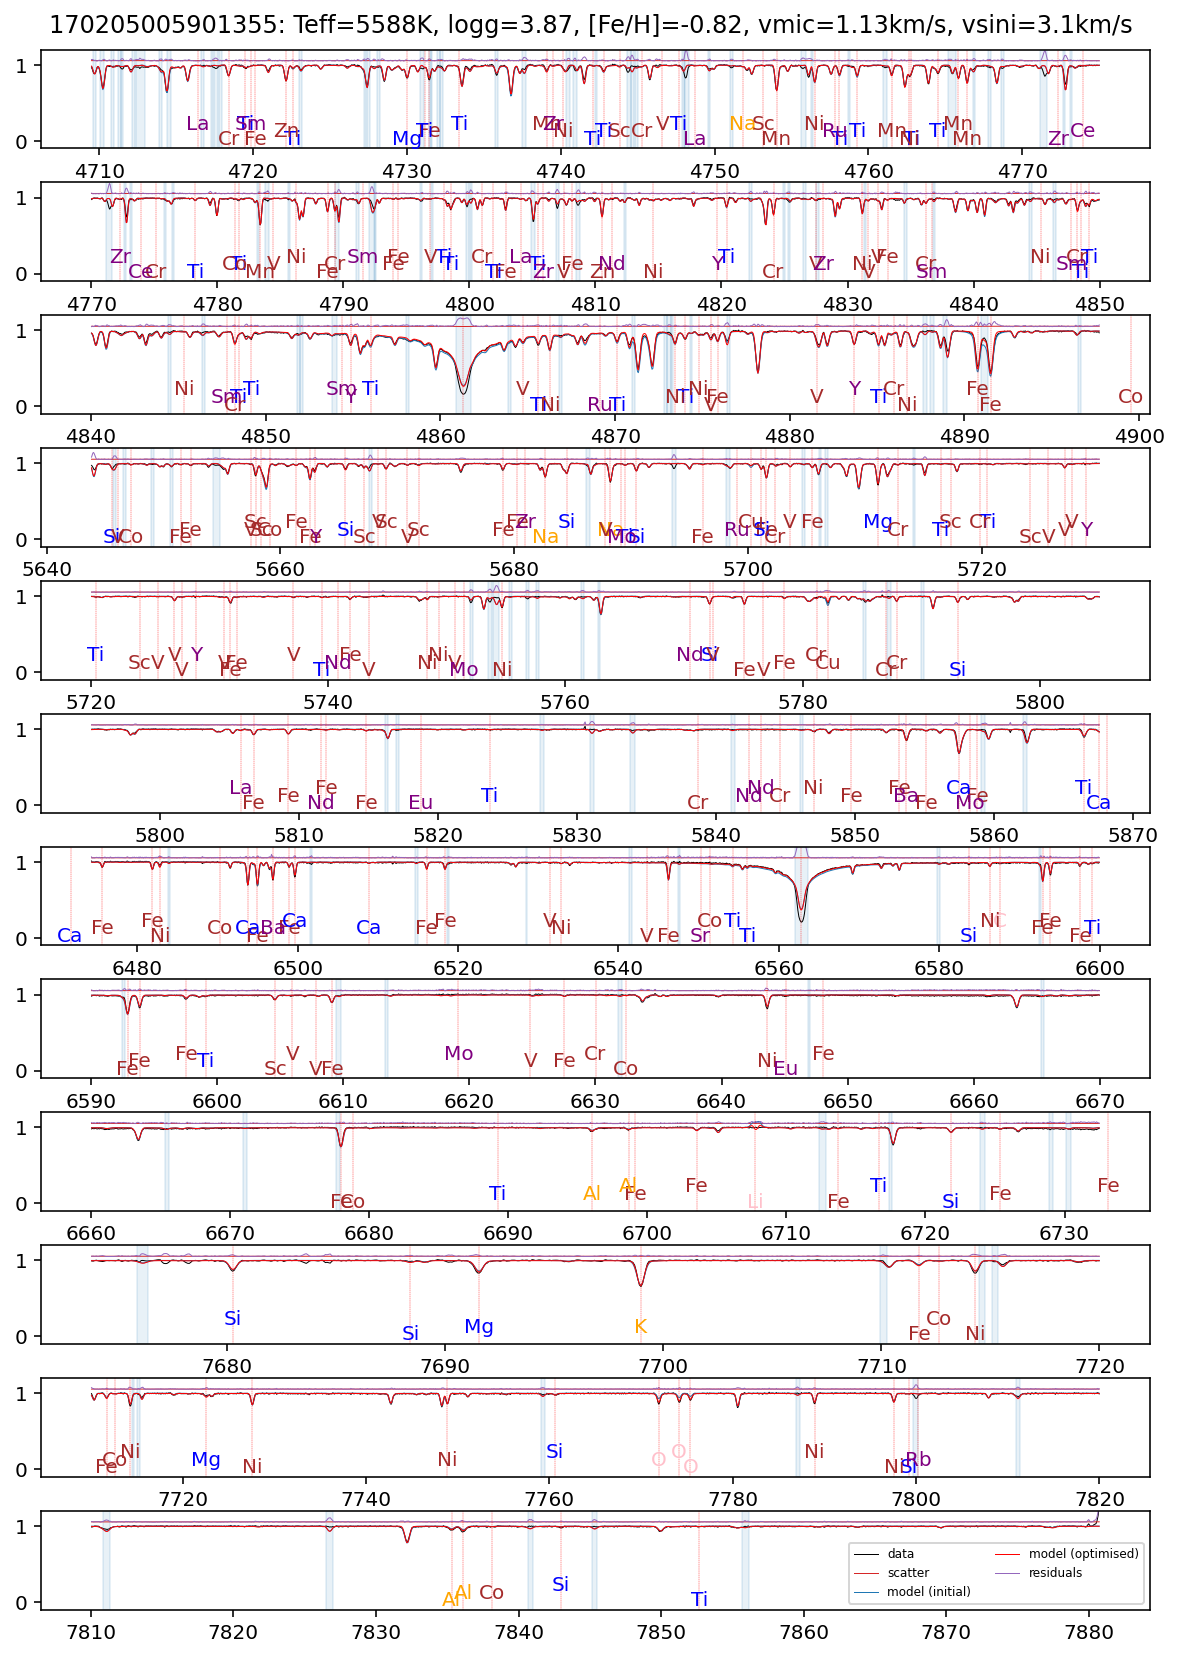

In [62]:
fig = plot_spectrum(
    wave_optimized,
    [
        data_optimized,
        model_init,
        model_optimized
    ],
    np.sqrt(data_sigma2_optimized+model_sigma2_optimized),
    str(sobject_id)+': '+
    'Teff='+str(int(np.round(output['teff'][0])))+'K, '+
    'logg='+str(np.round(output['logg'][0],decimals=2))+', '+
    '[Fe/H]='+str(np.round(output['fe_h'][0],decimals=2))+', '+
    'vmic='+str(np.round(output['vmic'][0],decimals=2))+'km/s, '+
    'vsini='+str(np.round(output['vsini'][0],decimals=1))+'km/s'
)

file_directory = working_directory+'/analysis_products/diagnostic_plots/'+str(spectrum['sobject_id'])[:6]+'/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

fig.savefig(file_directory+str(spectrum['sobject_id'])+'_stellar_parameter_spectrum_comparison_'+use_cannon_or_payne+'.pdf',overwrite=True,bbox_inches='tight')
plt.show()
plt.close()